In [56]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [57]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [133]:
### exact same code from previous lesson
chars = sorted(list(set(''.join(words))))
stoi = {s : i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)
block_size = 8 #content length, from how much do we want to predict next char

def build_dataset(iwords):  
    X, Y = [], []
    for w in iwords:
        # print(w)
        context = [0] * block_size #outputs [0,0,0]
        for chr in w + '.':
            ix = stoi[chr]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context) + ' ----> ' + itos[ix])
            context = context[1:] + [ix] #creating new list with new char appended to finish

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(1)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xval, Yval = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182345, 8]) torch.Size([182345])
torch.Size([22903, 8]) torch.Size([22903])
torch.Size([22898, 8]) torch.Size([22898])


In [145]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out) #/ fan_in**0.5 by introducing batchnorm, this initial normalization is not much necessary
        self.bias = torch.zeros(fan_out) if bias else None 

    def __call__(self, x):
        # (torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape ==> (4, 200) // for example considering 4 example
        # we want to group the output of 8 digits with 10 embedding to 4 groups of 2 of 10 embedding. WAVENET:: https://arxiv.org/pdf/1609.03499
        # like 1 2 3 4 5 6 7 8
        # to (1, 2) (3, 4) (5, 6) (7, 8) 
        # (torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape ==> (4, 4, 200) ==> this is how matrix mult works for multi dim tensors. ask gpt for more details it has good exp.
        

        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        #keyword of 'is' is so cool
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self,dim, momentum=0.1, eps=10**-5):
        self.training = True #are we doing training or val or test?
        self.momentum = momentum
        self.eps = eps
        self.bngain = torch.ones(dim)
        self.bnbias = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # xmean = x.mean(0, keepdim=True)
            # xvar = x.var(0, keepdim=True)
            #we introduced wavenet and this mean calc has bug
            #it computes mean over 4 groups seperately and individually, we want to calculate the channels over groups times number of batches
            # e = torch.randn(32, 4, 68) 
            # xmean = torch.mean(0, keepdim=True) (1, 4, 68)
            # xvar = torch.var(0, keepdim=True) (1, 4, 68)
            # ehat = (e - xmean) / torch.sqrt(xvar + 1) (32, 4, 68) BUG
            # e = torch.randn(32, 4, 68) 
            # xmean = torch.mean((0, 1), keepdim=True) (1, 1, 68)
            # xvar = torch.var((0, 1), keepdim=True) (1, 1, 68)
            # ehat = (e - xmean) / torch.sqrt(xvar + 1) (32, 4, 68) NOT BUG

            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            #this impl is good because any other dim would give us error, being explicit tends to be good for getting proper errors
            #this imp is bit different from torch lib where they dim as (0, 2). but we want 0,1.
            xmean = x.mean(dim, keepdim=True) #dont forget to take mean of x, not torch.mean :)
            xvar = x.var(dim, keepdim=True )
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xres = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.bngain * xres + self.bnbias
        
        if self.training:
            with torch.no_grad():
                self.running_mean  = (1 - self.momentum) * self.running_mean + self.momentum * xmean 
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.bnbias, self.bngain]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self): #just adding this self made error go away
        # TypeError: Tanh.parameters() takes 0 positional arguments but 1 was given
        return []
 
class Embedding:
    def __init__(self, num_embedding, dim_embedding):
        self.weight = torch.randn((num_embedding, dim_embedding))
        
        
    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out

    def parameters(self):
        return [self.weight]        

class FlattenWaveNet:
    # e = torch.randn(4, 8, 10) ==> (4, 4, 20)
    def __init__(self, n):
        self.n = n
    def __call__(self, x):
        # self.out = x.view(x.shape[0], -1)
        # self.out = x.view(x.shape[0], int(x.shape[1] / 2), -1) ==> this is also good idea but when any kind of error occurs, -1 keyword
        # doesnt properly give out a error message so explicitly arranging these values is much better. Andrej doesnt like -1 so i dont like -1
        B, T, C = x.shape #batch size, time, sequence length , channels/embeddings
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1) # 4, 1, 80 ==> 4, 80
        self.out = x
        return self.out
    
    def parameters(self):
        return []

class Sequential: 
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


n_embd = 10
n_hidden = 68
vocab_size = len(itos)

model = Sequential([
          Embedding(vocab_size, n_embd),
          FlattenWaveNet(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
          FlattenWaveNet(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
          FlattenWaveNet(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, vocab_size)
        ])
with torch.no_grad():
    model.layers[-1].weight *= 0.1
            

params = model.parameters()
print(f'Number of parameters created: {sum(p.nelement() for p in params)}')
count = 0
for p in params:
    p.requires_grad = True
# with this torchified implementation, we got deep understanding of how does torch lib and its nn liblary works, so in next lec, we will continue from
# standart torch lib. '''''never ever use something that you cannot create on your own. -- richard feynman'''''


Number of parameters created: 22397


In [146]:
ix = torch.randint(0, Xtr.shape[0], (4, ))
xb, yb = Xtr[ix], Ytr[ix]
logits = model(xb)
print(xb.shape)
xb


torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 10, 15],
        [ 0, 11, 18,  9, 19,  8,  1, 14],
        [ 0,  0,  0,  0,  0,  0, 12,  1],
        [ 0,  0,  0,  8,  1, 14,  9,  1]])

In [147]:
for layer in model.layers:
    print(f'{layer.__class__.__name__} :: {tuple(layer.out.shape)}')

Embedding :: (4, 8, 10)
FlattenWaveNet :: (4, 4, 20)
Linear :: (4, 4, 68)
BatchNorm1d :: (4, 4, 68)
Tanh :: (4, 4, 68)
FlattenWaveNet :: (4, 2, 136)
Linear :: (4, 2, 68)
BatchNorm1d :: (4, 2, 68)
Tanh :: (4, 2, 68)
FlattenWaveNet :: (4, 136)
Linear :: (4, 68)
BatchNorm1d :: (4, 68)
Tanh :: (4, 68)
Linear :: (4, 27)


In [148]:
steps = 50000
batch_s = 32
lossi = []
ud = []
for i in range(steps):

    #minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_s, ))  
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y

    #forward pass
    logits = model(Xb) 
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in params:
        p.grad = None
    loss.backward() # back propogration

    lr = 0.1 if i < steps * 0.75  else 0.01
    for p in params:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i=}/{steps=}=={loss.item():.4f}')
    lossi.append(loss.log10().item())


i=0/steps=50000==3.2970
i=10000/steps=50000==2.7465
i=20000/steps=50000==2.2383
i=30000/steps=50000==2.5775
i=40000/steps=50000==2.3593


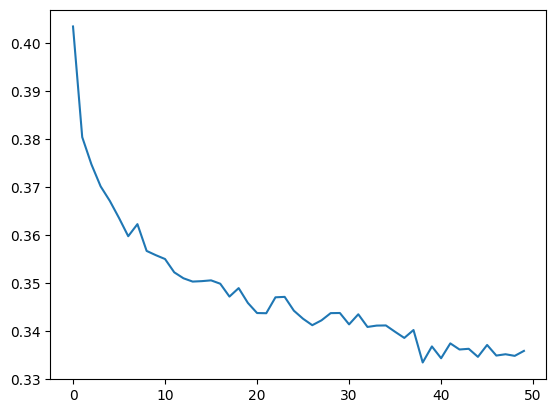

In [140]:
# this view is way too ugly
# plt.plot(lossi)
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [149]:
for layer in model.layers:
    layer.training = False

In [150]:
@torch.no_grad() #tells torch this func will not use any grad computation, basically disables grad.required to false to every variable. efficient
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.142873764038086
val 2.1616475582122803


In [151]:
for _ in range(20):
    out = []

    context = [0] * block_size 
    while True:
        logits = model(torch.tensor([context]))
        prob = torch.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1).item()
        context = context[1:] + [ix]  
        out.append(ix)
        
        if(ix == 0):
            break
        
    print(''.join(itos[i] for i in out))


mondry.
cherimy.
raylliewna.
koalee.
jesor.
aybuly.
damihont.
iyaeda.
cmikalah.
atdet.
kamhin.
zylo.
bith.
vinik.
deaz.
orpedig.
kyriag.
savi.
kanirus.
kahal.


In [144]:
## last notes
# andrej says that basically the time you spend on developing neural networks will be spend most at looking at nn documenation of torch and seeing
#which layers would work in my project and sticking them up with lego bricks however, the docs itself has very bad explanation on the topics itself and they may lie, they might be wrong in some cases
#but you just have to deal with it.

# there is lots of trials and erros on meking sure shapes of these layers actually work, like torch's bath norm would give you (0,2) mean dim but you would want
# (0, 1) is it (n c l) or (n l c) and so there is lots of gymnastics of code to make sure these shapes align ok. 

# he spends lots of his time in jupyter notebook making sure layers and their shapes align ok and then converting all of it to vs code


torch.Size([4, 4, 20])